## A user's guide to the DRT: software demo

This notebook accompanies the software demonstration section of the webinar. Sections 1, 4, and 5 were not covered in the webinar due to time constraints.

Contents:
1. Kramers-Kronig validation
2. Tuning the DRT
3. Analysis with the DRT
4. Handling constant-phase phenomena
5. The influence of impedance error structure

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# The line below can be changed to %matplotlib inline or %matplotlib notebook,
# depending on which backend you prefer
%matplotlib inline
from pathlib import Path
import colorsys

import pandas as pd

from hybdrt.models import DRT, DiscreteElementModel
import hybdrt.plotting as hplt
from hybdrt.utils.eis import complex_from_polar
import hybdrt.fileload as fl

%load_ext autoreload
%autoreload 2

In [3]:
# Create DRT instance for fitting
drt = DRT()

# Specify data location
datadir = Path("./data")

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


## 1. Kramers-Kronig validation

Here, we apply the Kramers-Kronig (KK) test to check the validity of two example spectra. 

The KK test is applied by fitting the DRT to the spectrum, using a very low regularization strength to avoid underfitting. Since the DRT describes a KK-compliant system by definition, it can only fit KK-compliant spectra. Thus, portions of the spectrum that diverge from the DRT fit are likely to be KK-invalid. (If the spectrum contains constant-phase contributions, it is best to incorporate the DOP using `drt.fit_dop = True` for the KK test - see Section 4 for more information on the DOP.)

(This was not covered in the webinar for brevity.)

### Example 1: Solid-state battery after discharge

This spectrum was measured on a lab-scale solid-state battery shortly after completing a discharge cycle.

array([<Axes: xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

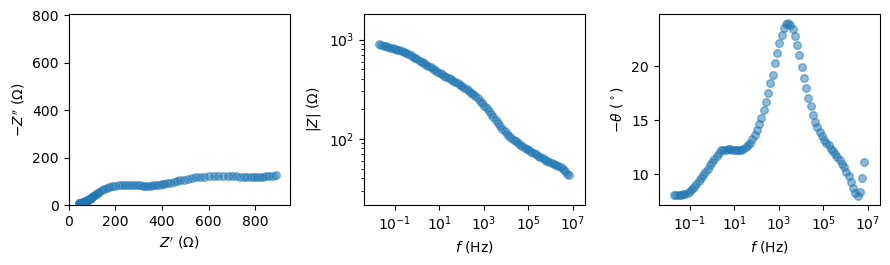

In [4]:
# Load and plot data
file1 = datadir.joinpath("SSB", "RateTest3_12_PEIS_C06.mpr")

# Load data from mpr file. Return a tuple: (freq, z)
fz1 = fl.read_eis(file1, return_tuple=True)


# First, plot the data
hplt.plot_eis(fz1, s=30)

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:1083: RuntimeWarning: divide by zero encountered in reciprocal
  sigma_vec = (weights ** -1)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\utils\eis.py:59: RuntimeWarning: invalid value encountered in multiply
  return z[:num_complex] + 1j * z[num_complex:]
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:1088: RuntimeWarning: invalid value encountered in multiply
  z_sigma = utils.eis.concat_vector_to_complex(sigma_vec) * self.impedance_scale


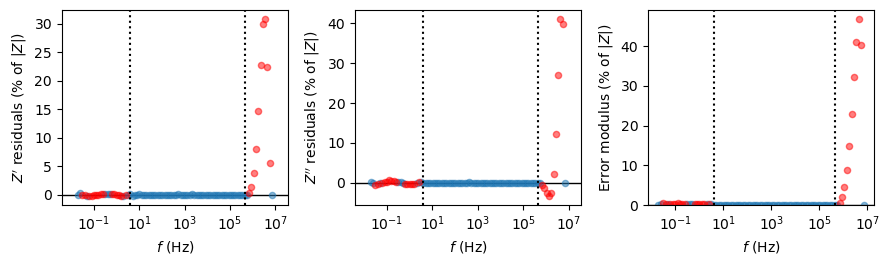

In [5]:
# Perform a KK test and plot the results
# ---------------------------------------
# Unpack tuple for fitting
freq, z = fz1
outlier_index, f_lim, fz_clean1 = drt.kk_test(freq, z, n_sigma=5, l2_lambda_0=1e-3)
axes = drt.plot_kk_results(outlier_index=outlier_index, f_lim=f_lim)

The KK test indicates substantial divergence from the DRT fit at both high and low frequencies (indicated by red markers with large residuals).

array([<Axes: xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

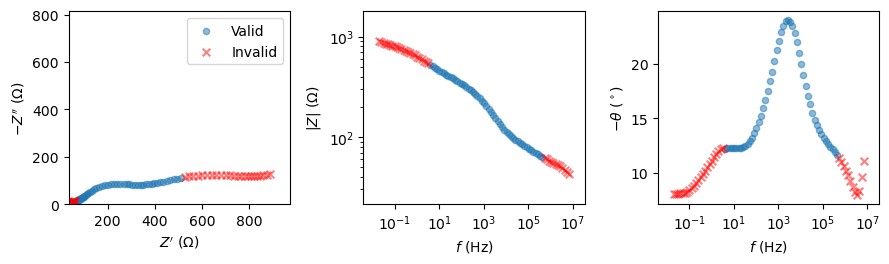

In [6]:
# Plot the spectrum with valid (blue) and invalid (red) points differentiated
axes = hplt.plot_eis(fz_clean1, s=20, label='Valid')

bad_mask = (freq < f_lim[0]) | (freq > f_lim[1])
fz_bad = tuple([x[bad_mask] for x in fz1])
hplt.plot_eis(fz_bad, axes=axes, c="r", s=30, label="Invalid", marker="x")

If we try to fit the full spectrum, we will find that the DRT fit diverges from the data in the invalid regions.

array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

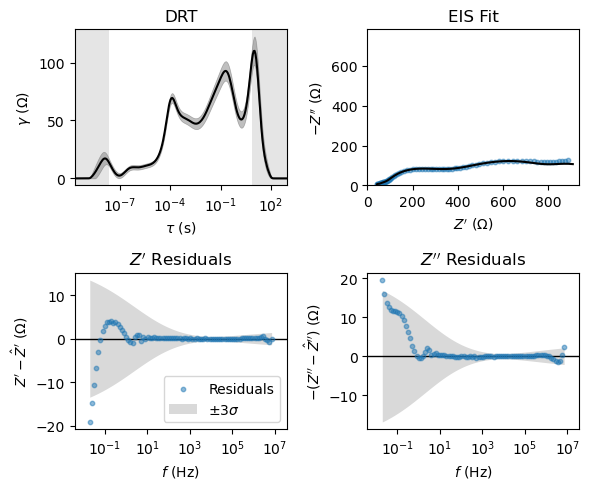

In [7]:
# Try fitting the DRT with bad points included
freq, z = fz1
drt.fit_eis(freq, z)

drt.plot_results()

Although a large portion of the spectrum is KK-invalid, we can fit the valid portion of the spectrum.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')


array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

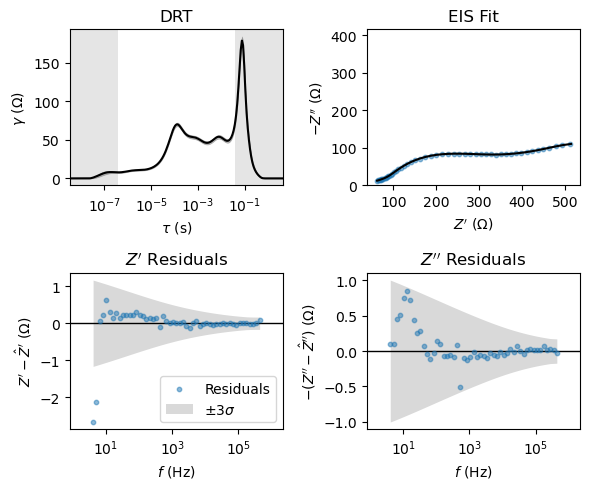

In [8]:
# Fit only the valid portion of the spectrum
drt.fit_eis(*fz_clean1)

drt.plot_results()

The large invalid region of this spectrum is likely due to insufficient rest time after battery operation, resulting in cell instability during the measurement.

### Example 2: Solid-state battery at rest

This spectrum was measured on a lab-scale solid-state battery that had been at rest for many hours.

array([<Axes: xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$|Z|$ ($\\Omega$)'>,
       <Axes: xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

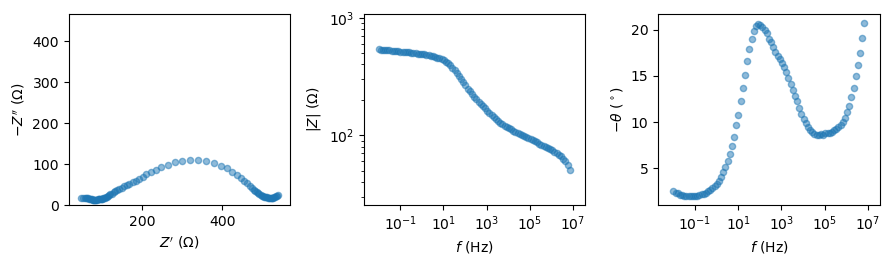

In [9]:
file = datadir.joinpath("SSB", "HybridVal4_Rest_Iac=0.0033C_Vac=5mV_C01_004_StandardPEIS.csv")

# Load csv data
df = pd.read_csv(file)

# Get data for a single EIS cycle
n = 0
cdf = df[df["loop_index"] == n]

# Extract frequency and z
freq = cdf["freq/Hz"].values

zr, zi = complex_from_polar(cdf.loc[:, ["|Z|/Ohm", "Phase(Z)/deg"]].values)
z = zr + 1j * zi

# Exclude erroneous 0-frequency point
mask = freq > 0
freq = freq[mask]
z = z[mask]

fz2 = (freq, z)

# Plot the data
hplt.plot_eis(fz2)


C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:1083: RuntimeWarning: divide by zero encountered in reciprocal
  sigma_vec = (weights ** -1)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\utils\eis.py:59: RuntimeWarning: invalid value encountered in multiply
  return z[:num_complex] + 1j * z[num_complex:]
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:1088: RuntimeWarning: invalid value encountered in multiply
  z_sigma = utils.eis.concat_vector_to_complex(sigma_vec) * self.impedance_scale


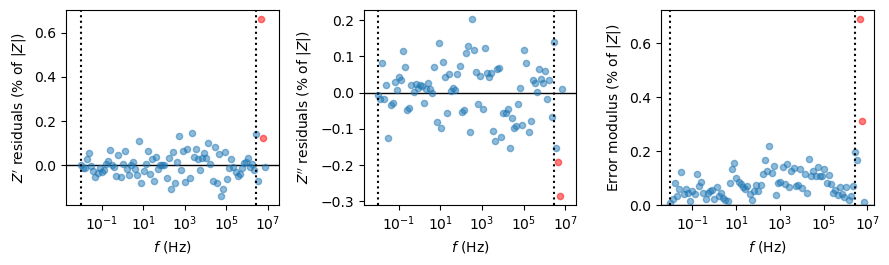

In [10]:
# Perform KK test and plot the results
freq, z = fz2
outlier_index, f_lim, fz_clean2 = drt.kk_test(freq, z, n_sigma=4)
axes = drt.plot_kk_results(outlier_index=outlier_index, f_lim=f_lim)

In this case, nearly the entire spectrum (except a few high-frequency points) is valid. We can obtain a good fit of the data with the DRT. 

array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

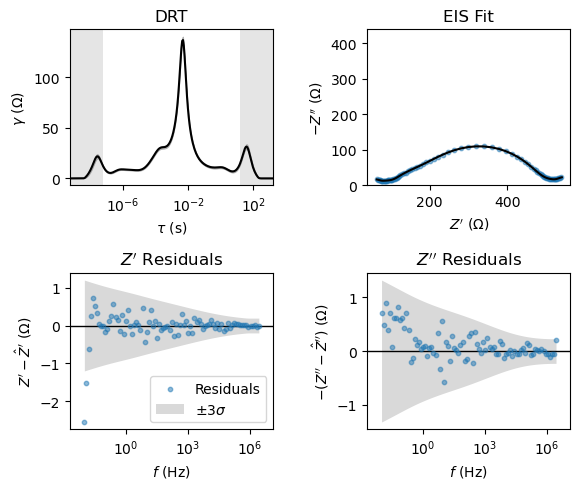

In [11]:
# Fit only the valid portion of the spectrum
drt.fit_eis(*fz_clean2)

drt.plot_results()

## 2. Tuning the DRT

This section demonstrates and compares several methods for tuning the DRT. We treat the regularization strength $\lambda$ as the main tuning parameter for this demonstration. However, many algorithms may contain 2 or more tuning parameters, which makes tuning more complex.

In [12]:
# Use the clean data from the SSB at rest
freq, z = fz_clean2

# Arguments to approximate ordinary ridge solution, disabling automatic tuning
or_kw = dict(
    max_iter=1, 
    error_structure="uniform",
    derivative_weights=np.array([0, 0, 1]),
    s_alpha=np.array([2, 2, 1e4]),
    rho_alpha=np.array([2, 2, 1e4]),
    penalty_type="integral"
)

### 2.1 Manual tuning

First, let's try manual tuning. We'll apply several different $\lambda$ values and compare the results, using our (subjective) judgement to evalute them.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')
C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iteratio

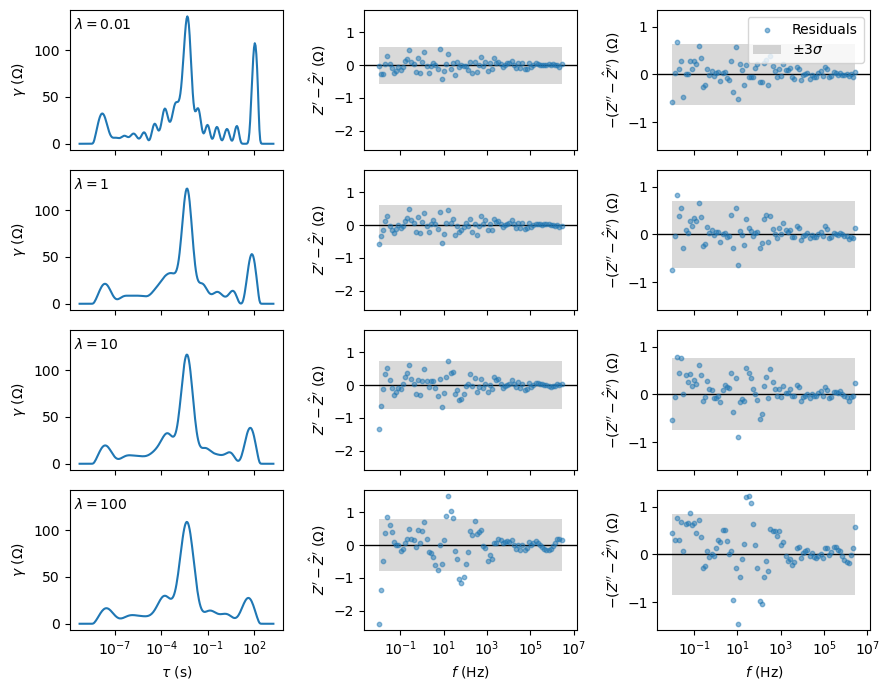

In [13]:
# Try a grid of lambda values
lambda_values = [0.01, 1, 10, 100]

fig, axes = plt.subplots(len(lambda_values), 3, sharex="col", sharey="col", figsize=(9, 7))

manual_fits = []
for i, l2 in enumerate(lambda_values):
    # Fit the data with the specified penalty strength (lambda)
    drt.fit_eis(freq, z, l2_lambda_0=l2, **or_kw)
    
    # Plot the estimated DRT
    drt.plot_distribution(ax=axes[i, 0], plot_ci=False)
    
    # Plot the corresponding impedance residuals 
    drt.plot_eis_residuals(axes=axes[i, 1:], scale_prefix="")
    
    # Label lambda value
    axes[i, 0].text(0.02, 0.95, rf"$\lambda={l2}$", ha="left", va="top", transform=axes[i, 0].transAxes)
    
    # Store a copy of the fit
    manual_fits.append(drt.copy())
    
for ax in axes[:-1].ravel():
    ax.set_xlabel("")

# Remove redundant legends    
axes[0, -1].legend(loc="upper right")
for ax in axes[1:, 2]:
    ax.get_legend().remove()
    
fig.tight_layout()


Based on these results, we might select $\lambda=1$ or $\lambda=10$ because they still provide a close fit of the data (small residuals) while reducing the degree of oscillation (probable pseudo-peaks).

array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

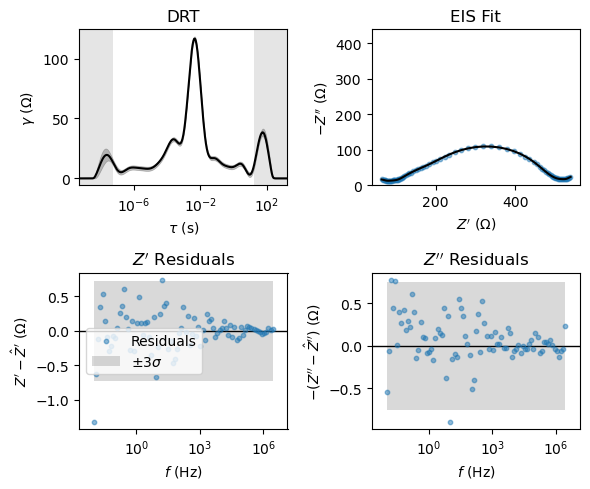

In [14]:
# Show the fit for the selected lambda value
fit = manual_fits[lambda_values.index(10)]
drt_man = fit

fit.plot_results()

### 2.2 Cross-validation (CV)

Cross-validation fits the DRT to different subsets of the data and checks how well each fit corresponds to the non-fitted portion of the data.

For simplicity, we split the data into two subsets randomly for this demonstration. Most established methods actually use Re-Im CV, in which the real and imaginary parts of the data are treated as two subsets. Since CV algorithms can behave differently depending on the configuration of the CV approach and the DRT model, I would recommend checking the literature for a more rigorous overview of different CV approaches.

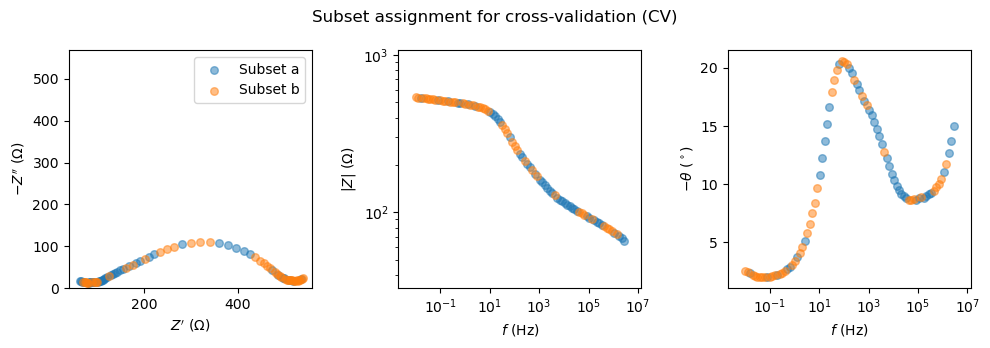

In [15]:
# Split spectrum randomly into subsets
# -------------------------------------------------------------------
rng = np.random.default_rng(1234)
a_index = rng.choice(len(freq), size=len(freq) // 2, replace=False)
# Order by descending frequency for convenience/consistency
a_index = np.sort(a_index)[::-1]

# Subset a
fz_a = tuple([np.delete(x, a_index) for x in fz_clean2])

# Subset b
fz_b = tuple([x[a_index] for x in fz_clean2])

# Plot both subsets
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
axes = hplt.plot_eis(fz_a, label="Subset a", axes=axes, s=30)
axes = hplt.plot_eis(fz_b, label="Subset b", axes=axes, s=30)

fig = axes[0].get_figure()
fig.suptitle("Subset assignment for cross-validation (CV)")
fig.tight_layout()

After splitting the spectrum into two subsets, we can fit each subset separately and use the fit to predict the other subset.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')


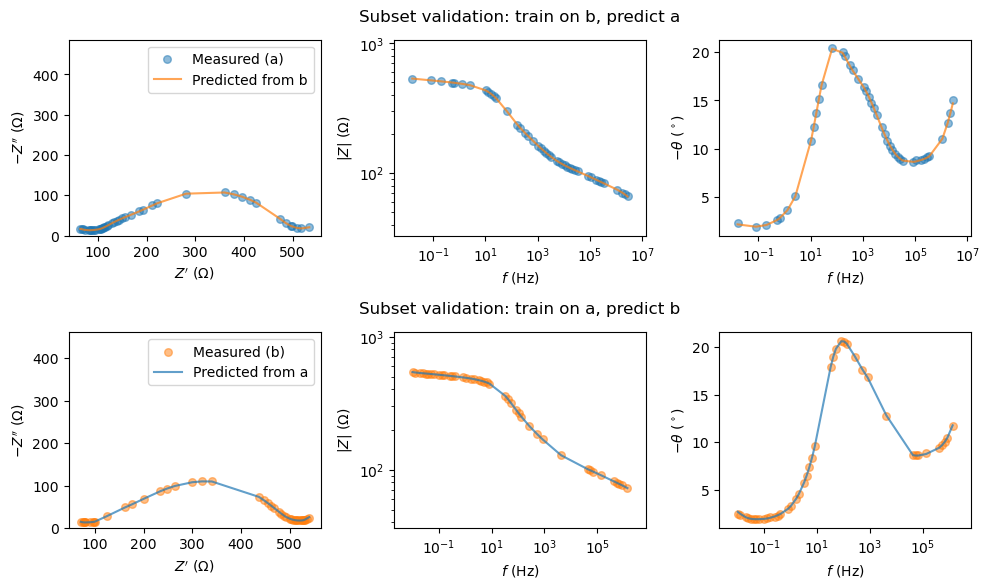

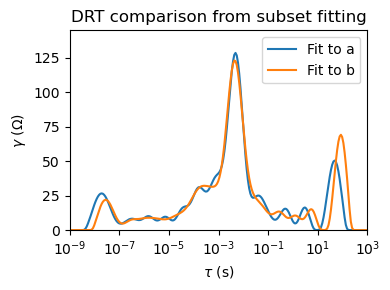

In [16]:
# Illustrate the cross-validation procedure for a single lambda value
# -------------------------------------------------------------------
# Fit to subset a
drt.fit_eis(*fz_a, **or_kw, l2_lambda_0=0.1)
drt_a = drt.copy()

# Fit to subset b
drt.fit_eis(*fz_b, **or_kw, l2_lambda_0=0.1)
drt_b = drt.copy()

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for i, (fz_sub, fit) in enumerate(zip((fz_a, fz_b), (drt_b, drt_a))):
    # Use the DRT fitted to the other subset to predict this subset
    # e.g., for subset a, use the drt_b to predict
    f, z_sub = fz_sub
    z_pred = fit.predict_z(f)
    
    # axes = axes[i]
    
    hplt.plot_eis(fz_sub, axes=axes[i], label="Meas.", c=f"C{i}", s=30)
    hplt.plot_eis((f, z_pred), axes=axes[i], plot_func="plot", label="Pred", alpha=0.7, c=f"C{1 - i}")
    
axes[0, 0].legend(labels=["Measured (a)", "Predicted from b"])
axes[1, 0].legend(labels=["Measured (b)", "Predicted from a"])

axes[0, 1].set_title("Subset validation: train on b, predict a", y=1.05)
axes[1, 1].set_title("Subset validation: train on a, predict b", y=1.05)
fig.tight_layout()
    
# Compare the DRTs obtained from the 2 subsets
fig2, ax2 = plt.subplots(figsize=(4, 3))

drt_a.plot_distribution(ax=ax2, label="Fit to a")
drt_b.plot_distribution(ax=ax2, label="Fit to b")

ax2.set_title("DRT comparison from subset fitting")
ax2.set_xlim(1e-9, 1e3)
ax2.set_ylim(0, 145)
ax2.legend()
fig2.tight_layout()

To optimize $\lambda$, we perform this cross-validation for many different $\lambda$ values and find the point at which the cross-validation error is minimized.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 1 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')


best lambda = 3.2e-02


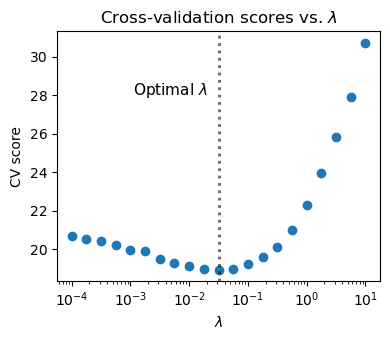

In [17]:
# Perform cross-validation
# -------------------------------------------------------------------
# Try a grid of lambda values
cv_lambdas = np.logspace(-4, 1, 21)

cv_fits = []
cv_scores = np.empty(len(cv_lambdas))

# At each lambda value:
# 1. Fit the DRT to subset a, then use it to predict subset b and calculate the prediction error
# 2. Repeat with subsets switched (fit b, predict a)
for i, l2 in enumerate(cv_lambdas):
    # Fit to subset a
    drt.fit_eis(*fz_a, **or_kw, l2_lambda_0=l2)
    
    # Predict subset b and get errors
    z_pred_b = drt.predict_z(fz_b[0])
    z_err_b = fz_b[1] - z_pred_b

    # Fit to subset b
    drt.fit_eis(*fz_b, **or_kw, l2_lambda_0=0.1)
    
    # Predict subset a and get errors
    z_pred_a = drt.predict_z(fz_a[0])
    z_err_a = fz_a[1] - z_pred_a
    
    # Sum squared errors across both subsets
    rss = np.sum(np.abs(z_err_b) ** 2) + np.sum(np.abs(z_err_a) ** 2)
    cv_scores[i] = rss
    
    
fig, ax = plt.subplots(figsize=(4, 3.5))

ax.scatter(cv_lambdas, cv_scores)
ax.set_xscale("log")
    
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("CV score")

best_index = np.argmin(cv_scores)
best_lambda = cv_lambdas[best_index]
ax.axvline(best_lambda, c="k", ls=":", alpha=0.6, lw=2)
ax.text(best_lambda / 1.5, 28, r"Optimal $\lambda$", ha="right", size=11)

print("best lambda = {:.1e}".format(best_lambda))

ax.set_title(r"Cross-validation scores vs. $\lambda$")
fig.tight_layout()

We can now use this optimized $\lambda$ to fit the entire dataset.

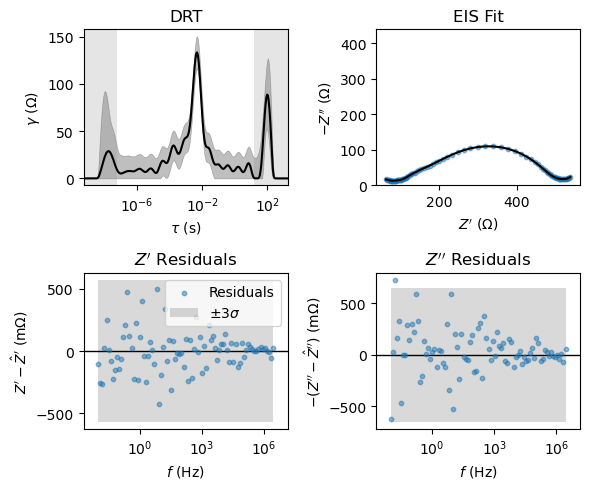

In [18]:
# Fit using the best lambda value from CV
drt.fit_eis(*fz_clean2, l2_lambda_0=best_lambda, **or_kw)

# Store a copy
drt_cv = drt.copy()

# Plot the results
axes = drt.plot_results()
axes[1, 0].legend(loc="upper right")

In this case, the optimal $\lambda$ value obtained via CV seems to result in overfitting, as indicated by the strong oscillation of the estimated DRT. Once again, this may not be representative of the performance of CV algorithms in general; this is just a demonstration of the concept.

### 2.3 Automatic tuning

Finally, we can apply the automatic tuning method implemented in `hybrid-drt`, which uses a hierarchical Bayesian model to optimize many hyperparameters at once. We don't need to perform CV or manually adjust parameters. The algorithm behind `hybrid-drt` is described in [this work](https://doi.org/10.1016/j.electacta.2023.141879).

array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

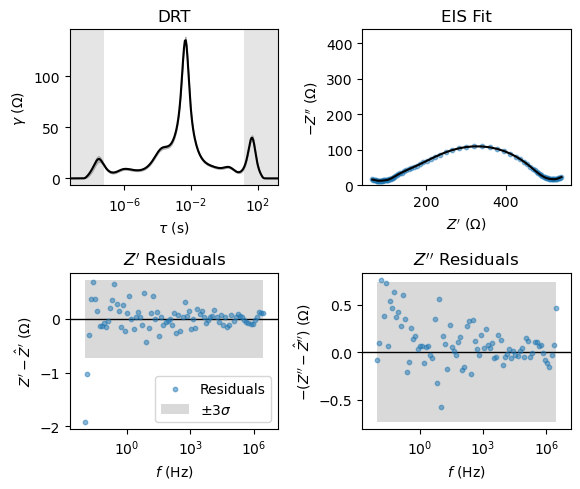

In [19]:
# Fit with default settings (automatic tuning)
drt.fit_eis(*fz_clean2, error_structure="uniform")

# Store a copy
drt_auto = drt.copy()

# Plot results
drt.plot_results()

### 2.4 Comparison 

We can now compare the results obtained with the three different methods.

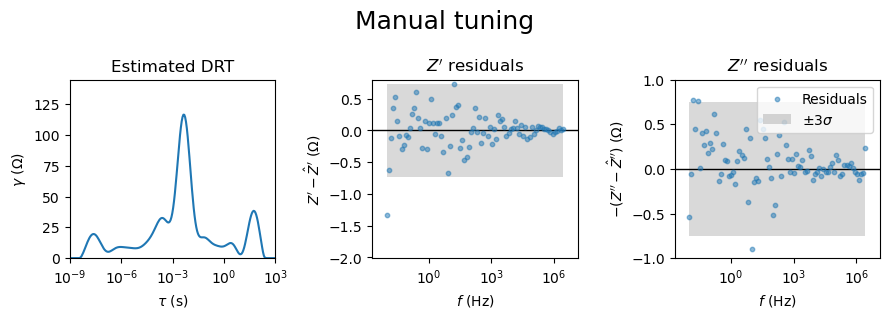

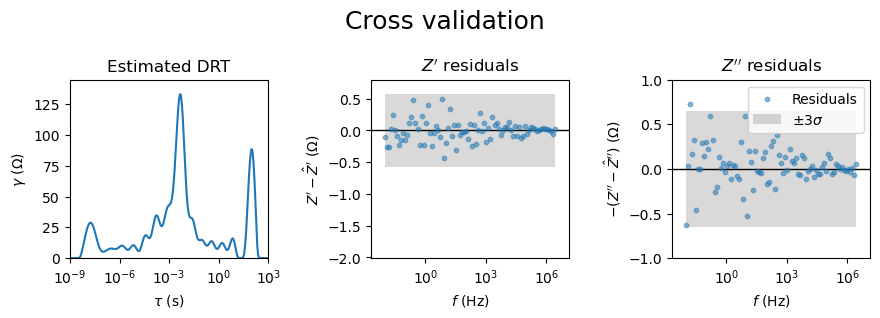

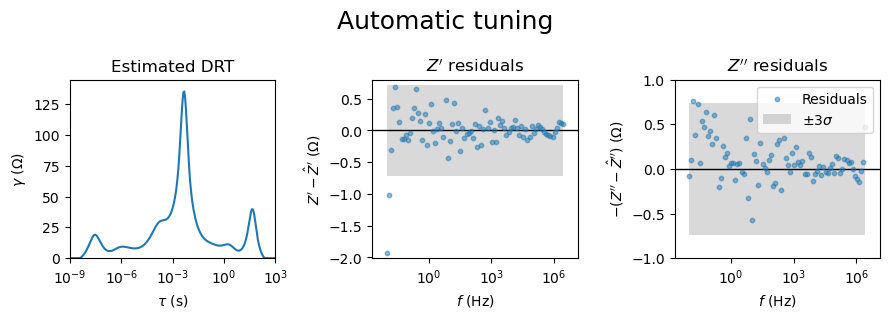

In [20]:
# Compare auto tuning to CV tuning
# ---------------------------------

titles = ["Manual tuning", "Cross validation", "Automatic tuning"]
for i, fit in enumerate([drt_man, drt_cv, drt_auto]):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3.2))
    
    fit.plot_distribution(ax=axes[0])
    fit.plot_eis_residuals(axes=axes[1:], scale_prefix="")
    
    axes[0].set_xlim(1e-9, 1e3)
    axes[0].set_ylim(0, 145)
        
    # Set consistent axis limits
    
    axes[1].set_ylim(-2.01, 0.8)
    axes[2].set_ylim(-1, 1)
        
        
    axes[-1].legend(loc="upper right")
    
    for ax, label in zip(axes, ["Estimated DRT", r"$Z^\prime$ residuals", r"$Z^{\prime\prime}$ residuals"]):
        ax.set_title(label)
    fig.suptitle(titles[i], size=18)


    fig.tight_layout()
    

## 3. Analysis with the DRT

Using the automatically tuned DRT, we can now perform further analyses: peak identification, peak quantification, and model selection.

First, let's examine how the DRT extrapolates beyond the measured frequency range (a necessity of the fitting process).

C:\Users\jhuang2\python\hybrid-drt\hybdrt\plotting.py:289: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * x)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\plotting.py:289: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * x)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\plotting.py:289: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * x)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\plotting.py:289: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * x)
C:\Users\jhuang2\python\hybrid-drt\hybdrt\plotting.py:289: RuntimeWarning: divide by zero encountered in divide
  return 1 / (2 * np.pi * x)


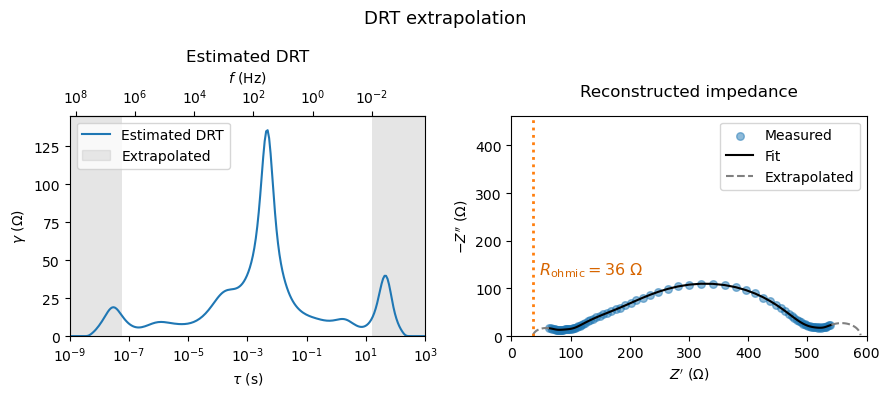

In [21]:
def adjust_lightness(color, amount):
    # Adjust color for better text visibility
	try:
		c = mpl.colors.cnames[color]
	except:
		c = color
	c = colorsys.rgb_to_hls(*mpl.colors.to_rgb(c))
	# print(c)
	return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

# Show the bounds of the DRT
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
drt_auto.plot_distribution(ax=axes[0], shade_extrap=True, freq_axis=True, label="Estimated DRT")
axes[0].axvspan(1e5, 1e6, color="gray", alpha=0.15, label="Extrapolated")
axes[0].legend(loc="upper left")
axes[0].set_xlim(1e-9, 1e3)
axes[0].set_ylim(0, 145)

# Show the impedance reconstruction
drt_auto.plot_eis_fit(axes=axes[1], data_label="Measured", label="Fit", data_kw={"s": 30})

# Show DRT extrapolation beyond the measured range
f_meas = fz_clean2[0]
f_extrap = [
    np.logspace(8, np.log10(f_meas[0]), 50),
    np.logspace(np.log10(f_meas[-1]), -4, 50)
    ]
for i, fe in enumerate(f_extrap):
    drt_auto.plot_eis_fit(axes=axes[1], frequencies=fe, plot_data=False,
                          c="gray", ls="--",
                          label="Extrapolated" if i == 0 else "")

# Show ohmic offset    
hplt.zoom_nyquist_x(axes[1], (0, 600), ymin=0)
R_ohm = drt_auto.predict_r_inf()
axes[1].axvline(R_ohm, c="C1", ls=":", lw=2)
axes[1].text(R_ohm * 1.3, 130, rf"$R_{{\mathrm{{ohmic}}}}={R_ohm:.0f} \ \Omega$", c=adjust_lightness("C1", 0.8), size=11.5, fontweight="bold")

axes[0].set_title("Estimated DRT")
axes[1].set_title("Reconstructed impedance", y=1.05)

fig.suptitle("DRT extrapolation", size=13)
fig.tight_layout()


### 3.1 Peak identification

We can identify peaks in the DRT with an automated peak finding algorithm.

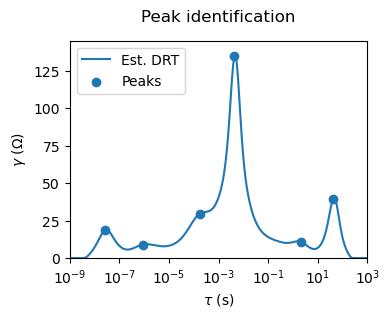

In [22]:
# Find peaks in the DRT
fig, ax = plt.subplots(figsize=(4, 3.3))
drt_auto.plot_distribution(mark_peaks=True, ax=ax, label="Est. DRT", mark_peaks_kw={"label": "Peaks"})

# Formatting
ax.set_title("Peak identification", y=1.05)
ax.set_xlim(1e-9, 1e3)
ax.set_ylim(0, 145)
ax.legend(loc="upper left")
fig.tight_layout()

### 3.2 Peak quantification

We can quantify the area under each peak to estimate the resistance of the corresponding process(es).

We can do this non-parametrically, i.e. by splitting the total DRT into sub-distributions assigned to each peak. This may yield non-physical peak shapes, but it gives us an initial estimate of peak areas without having to define a model or assume a certain peak shape. 

For parametric quantification with meaningful peak shapes, we can convert the DRT to a circuit model, as shown in the next section.

Peak parameters:
P1: tau=2.7e-08 s, R=40.3 Ohms, C=6.7e-10 F
P2: tau=8.5e-07 s, R=25.7 Ohms, C=3.3e-08 F
P3: tau=1.7e-04 s, R=136.8 Ohms, C=1.2e-06 F
P4: tau=4.3e-03 s, R=266.3 Ohms, C=1.6e-05 F
P5: tau=2.1e+00 s, R=23.7 Ohms, C=9.0e-02 F
P6: tau=4.3e+01 s, R=60.7 Ohms, C=7.0e-01 F


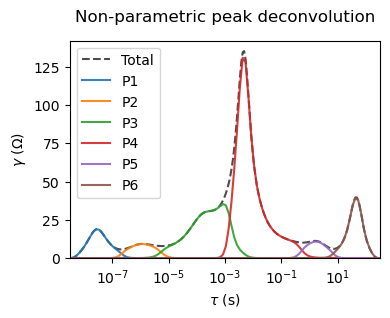

In [23]:
# Non-parametric peak quantification
estimate_peak_distributions_kw = {"epsilon_factor": 1.5}

fig, ax = plt.subplots(figsize=(4, 3.3))
# Plot the total distribution
ax = drt_auto.plot_distribution(c="k", ls="--", alpha=0.7, ax=ax)
# Plot the estimated distribution of each peak (non-parametric)
drt_auto.plot_peak_distributions(ax=ax, alpha=0.9, estimate_peak_distributions_kw=estimate_peak_distributions_kw)

ax.legend(labels=["Total"] + [f"P{i}" for i in range(1, 7)], loc="upper left")
ax.set_xlim(10 ** -8.5, 10 ** 2.5)
ax.set_ylim(0, ax.get_ylim()[1])

# Get peak resistances
peak_areas = drt_auto.quantify_peaks(**estimate_peak_distributions_kw)

# Get peak time constants
peak_tau = drt_auto.find_peaks()

# Get peak capacitances
# tau = R * C -> C = tau / R
peak_cap = peak_tau / peak_areas


print("Peak parameters:")
for i in range(len(peak_areas)):
    print(fr"P{i + 1}: tau={peak_tau[i]:.1e} s, R={peak_areas[i]:.1f} Ohms, C={peak_cap[i]:.1e} F")
    

ax.set_title("Non-parametric peak deconvolution", y=1.05)
ax.get_figure().tight_layout()

### 3.3 Model selection

We can also use the DRT to define a circuit model. Converting each peak into an R-CPE (aka ZARC or RQ) element yields a circuit consisting of 6 R-CPE elements (plus an ohmic resistance and inductance in series). We can quickly fit this circuit model to the data by using the DRT to initialize the parameters. This is also a means parametric peak quantification - each DRT peak is treated with the distribution corresponding to the R-CPE element.

In [24]:
# Select a circuit model based on peaks in the DRT
# Find peaks in the DRT
peak_tau, tau_eval, peak_indices, peak_info = drt_auto.find_peaks(return_info=True)

# Create a circuit model, treating each peak as an RQ element
dem = DiscreteElementModel.from_drt(drt_auto, tau=tau_eval, peak_indices=peak_indices, drt_element="RQ")
# Fit the circuit model to the data, using the DRT to initialize parameter values
dem.fit_eis(*fz_clean2, from_drt=True, prior=False)

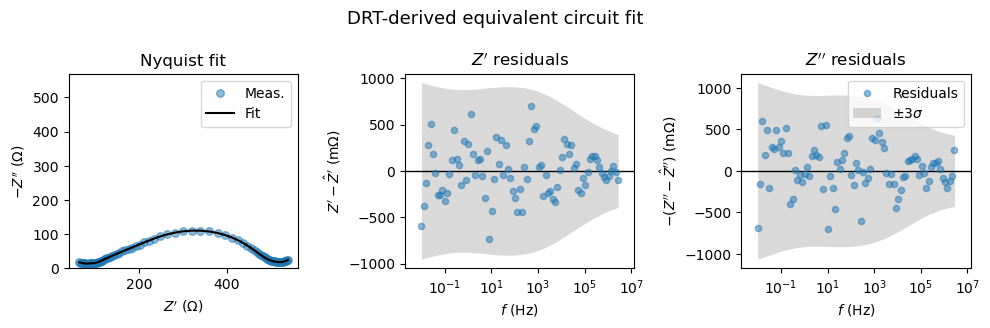

In [25]:
# Plot the circuit model fit
fig, axes = plt.subplots(1, 3, figsize=(10, 3.3))
dem.plot_eis_fit(axes=axes[0], label="Fit", data_label="Meas.", data_kw={"s": 30})
dem.plot_eis_residuals(axes=axes[1:])
axes[2].legend(loc="upper right")

# Reset nyquist aspect after adding residuals (axes are resized)
hplt.set_nyquist_aspect(axes[0], "x")

for ax, label in zip(axes, ["Nyquist fit", r"$Z^\prime$ residuals", r"$Z^{\prime\prime}$ residuals"]):
    ax.set_title(label)
fig.suptitle("DRT-derived equivalent circuit fit", size=13)
fig.tight_layout()


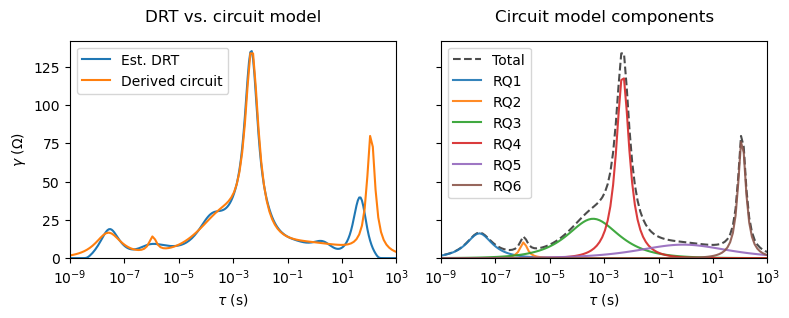

In [26]:
# Show the equivalent DRT of the circuit

fig, axes = plt.subplots(1, 2, figsize=(8, 3.3), sharex=True, sharey=True)

# Plot estimated DRT
drt_auto.plot_distribution(ax=axes[0], label="Est. DRT")
# Plot equivalent DRT of circuit model
dem.plot_distribution(tau_eval, show_singularities=False, ax=axes[0], label="Derived circuit")
dem.plot_distribution(tau_eval, show_singularities=False, ax=axes[1], label="Total", ls="--", c="k", alpha=0.7)

# Plot DRTs corresponding to individual elements of circuit model
kw_list = [dict(label=f"RQ{i + 1}") for i in range(6)]
dem.plot_element_distributions(tau_eval, alpha=0.9, ax=axes[1], kw_list=kw_list)

# Formatting
axes[0].legend()
axes[1].legend()

axes[0].set_xlim(10 ** -9, 10 ** 3)
axes[0].set_ylim(0, axes[0].get_ylim()[1])

axes[1].set_ylabel("")

axes[0].set_title("DRT vs. circuit model", y=1.05)
axes[1].set_title("Circuit model components", y=1.05)

fig.tight_layout()

## 4. Handling constant-phase phenomena 

Sometimes, spectra contain constant-phase contributions (straight lines in the Nyquist plot) like low-frequency pseudo-capacitance or Warburg diffusion, or high-frequency pseudo-inductance. We cannot easily fit these phenomena with the DRT, because the DRT inherently describes RC-type processes (semicircles in the Nyquist plot). 

Here, we show how the DRT is perturbed if we try to fit constant-phase processes directly with the DRT. A better approach is to incorporate a specific series element (like a CPE or inductor) to capture constant-phase contributions. Here, we use a constant-phase analog of the DRT, the distribution of phasances (DOP) (described in [this work](https://www.cell.com/joule/fulltext/S2542-4351(24)00203-4)) to treat constant-phase processes separately.

To illustrate, we use a measurement from the Li-ion conductor Li<sub>6</sub>PS<sub>5</sub>Cl (LPSCl) between ion-blocking electrodes. The spectrum contains a high-frequency semicircle, corresponding to Li-ion transport through LPSCl, and a low-frequency constant-phase tail due to the blocking electrodes.

(This was not covered in the webinar due to time constraints.)

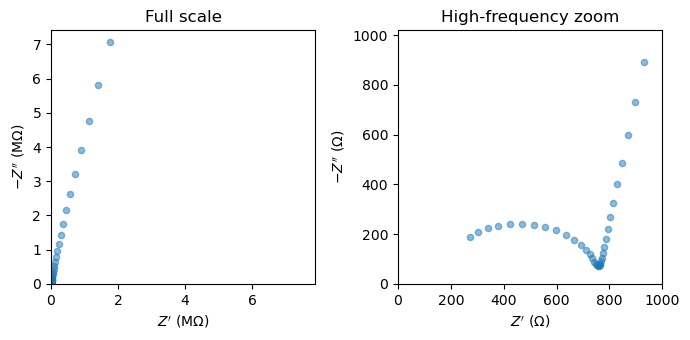

In [27]:
# Load data
# files = list(datadir.joinpath("LPSCl").glob("*.mpr"))

file = datadir.joinpath("LPSCl", "PEIS_TSeq6_-15C_#56_C01.mpr")
fz_lpscl = fl.read_eis(file, return_tuple=True)
# data = {}
# for file in files:
#     temp = float(file.name.split("_")[2][:-1])
#     data[temp] = fl.read_eis(file, return_tuple=True)

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
hplt.plot_nyquist(fz_lpscl, ax=axes[0])
hplt.plot_nyquist(fz_lpscl, ax=axes[1], scale_prefix="")
    
# Zoom in on the high-frequency semicircle
hplt.zoom_nyquist_x(axes[1], (0, 1e3), ymin=0)

axes[0].set_title("Full scale")
axes[1].set_title("High-frequency zoom")

fig.tight_layout()


array([[<Axes: title={'center': 'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ (k$\\Omega$)'>,
        <Axes: title={'center': 'EIS Fit'}, xlabel='$Z^\\prime$ (k$\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ (k$\\Omega$)'>],
       [<Axes: title={'center': '$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$Z^{\\prime} - \\hat{Z}^{\\prime}$ ($\\Omega$)'>,
        <Axes: title={'center': '$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(Z^{\\prime\\prime} - \\hat{Z}^{\\prime\\prime})$ ($\\Omega$)'>]],
      dtype=object)

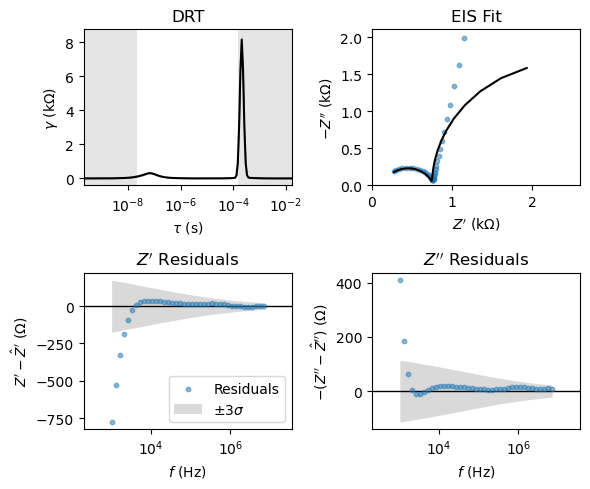

In [28]:
# Attempt a direct DRT fit
# Since we're interested in the semicircle (ion transport), let's limit the data to high frequencies
f, z = fz_lpscl
mask = f >= 1e3

drt.fit_eis(f[mask], z[mask])

drt.plot_results()

Directly fitting the spectrum with the DRT does not work well. The DRT cannot capture the straight-line tail due to the blocking electrode, resulting in a large divergence of the fit from the data. The blocking electrode tail also creates a peak in the DRT near $\tau=10^{-4}$, which does not actually represent an RC process.

Next, we fit the spectrum again, but use the DOP to capture the blocking tail. The DOP is a 2nd distribution that is placed in series with the DRT to capture constant-phase processes.

C:\Users\jhuang2\python\hybrid-drt\hybdrt\models\drt1d.py:986: UserWarning: Solution did not converge within 50 iterations. This is usually not an issue.
  warnings.warn(f'Solution did not converge within {max_iter} iterations. This is usually not an issue.')


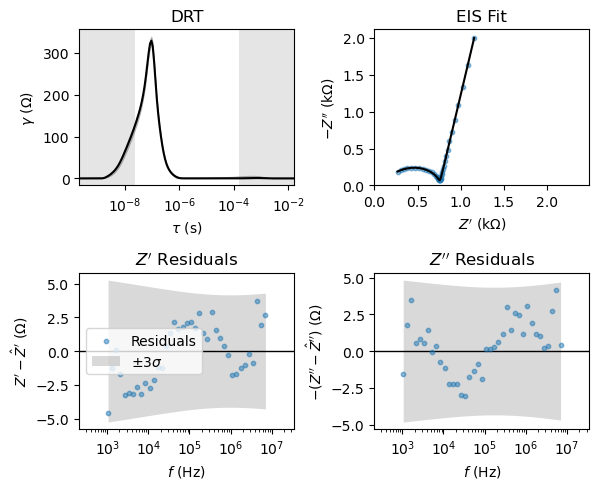

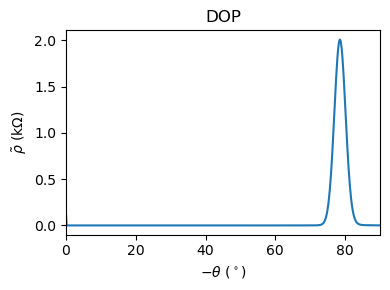

In [29]:
# Fit with the DOP included
dop = drt.copy()
dop.fit_dop = True
dop.fit_eis(f[mask], z[mask])

# Plot the DRT and fit results
dop.plot_results()

# Plot the DOP component
ax = dop.plot_dop(normalize=True)
ax.set_xlim(0, 90)
ax.set_title("DOP")
ax.get_figure().tight_layout()

The DRT-DOP model yields a much better fit of the data. The DOP captures the blocking electrode process with a peak near $80^\circ$, indicating the phase angle of the low-frequency tail. Meanwhile, the DRT shows only a single peak near  $\tau=10^{-7}$ s, corresponding to the ion transport semicircle. This is similar to modeling the data using the DRT in series with a CPE.

## 5. The effect of impedance error structure

Our assumptions about the error structure of the impedance data - that is, how the measurement error varies over the frequency range - can influence DRT estimation (and equivalent circuit fits). We fit the SSB spectrum from earlier assuming three different error structures: uniform (constant error), modulus (error proportional to impedance modulus), and adaptive (agnostic error structure estimated from the data). By default, `hybrid-drt` uses an adaptive error structure.

(This was not covered in the webinar due to time constraints.)

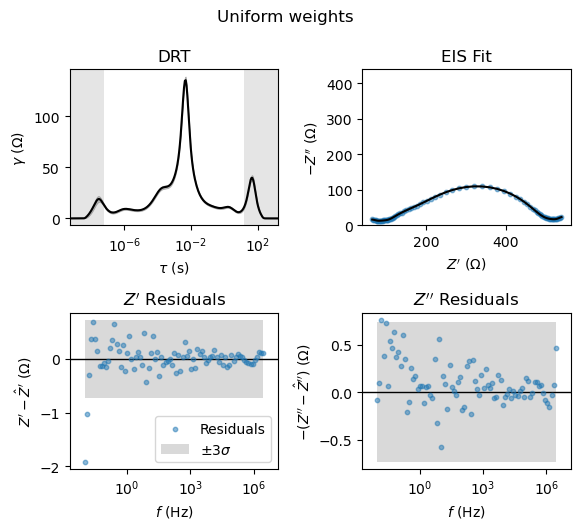

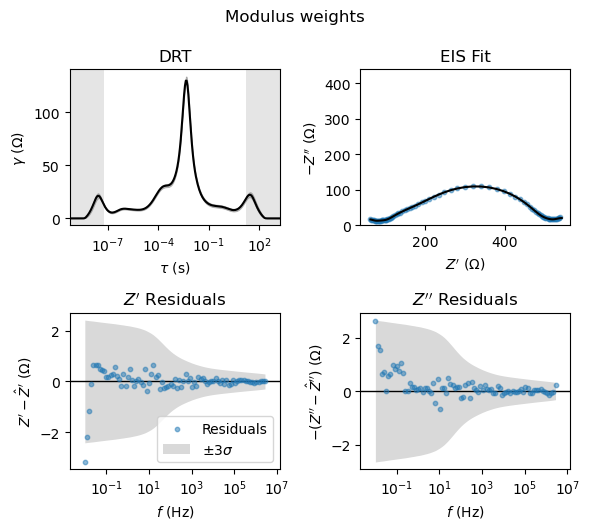

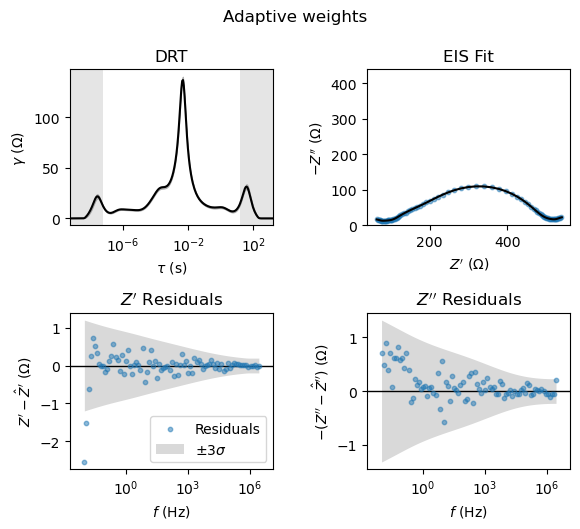

In [30]:
# Use SSB data at rest
freq, z = fz_clean2

# Modulus weights - scale to unit mean
mod_weights = 1 / np.abs(z)
mod_weights /= np.mean(mod_weights)

kws = {
    "Uniform": dict(error_structure="uniform"),
    "Modulus": dict(error_structure="uniform", weight_factor=np.tile(mod_weights, 2)),
    "Adaptive": dict(),  # default settings
}

# Fit with each error structure
fits = {}

for key, kw in kws.items():
    drt.fit_eis(freq, z, **kw)
    fits[key] = drt.copy()
    
    axes = drt.plot_results()
    axes[0, 0].get_figure().suptitle(f"{key} weights", y=1.05)

Although the differences in the estimated DRT are subtle, one can see from the estimated $\pm 3 \sigma$ range that each error structure gives different weights to different portions of the spectrum. Below, we overlay the DRT estimates to show how this affects the model.

(0.0, 145.0)

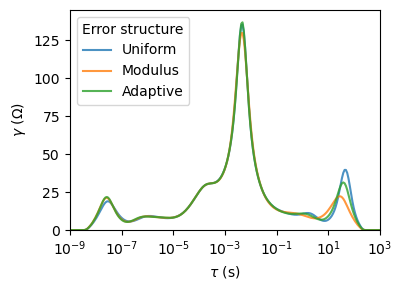

In [31]:
# Compare DRTs obtained with each error structure
fig, ax = plt.subplots(figsize=(4, 3))
for key, fit in fits.items():
    fit.plot_distribution(ax=ax, label=key, alpha=0.8)
    
ax.legend(title="Error structure", loc="upper left")
ax.set_xlim(1e-9, 1e3)
ax.set_ylim(0, 145)

The uniform structure gives slightly less weight to high frequencies, resulting in a smaller peak near $\tau=10^{-8}$ s, but more weight to low frequencies, resulting in a larger peak near $\tau=10^{2}$ s. Modulus does the inverse, giving more weight to high frequencies and less weight to low frequencies. The adaptive structure falls somewhere in the middle.